In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
import os
import matplotlib.pyplot as plt

def get_bool_mask(df_gt, df_ids):
    return np.array(df_gt["Sample_ID"].isin(df_ids))

## Train - Test split

In [3]:
def plot_splits(samples, train_idx):
    samples["Split type"] = np.where(samples["Sample_ID"].isin(train_idx), "Train", "Test")
    samples["Split type"] = pd.Categorical(samples["Split type"], ["Test", "Train"])
    samples.sort_values("Split type", inplace=True)
    sns.histplot(x=samples["Pam50 Subtype"], hue=samples["Split type"], multiple = "fill")
    plt.title("Proportions of MoGCN train-test splits for each class")

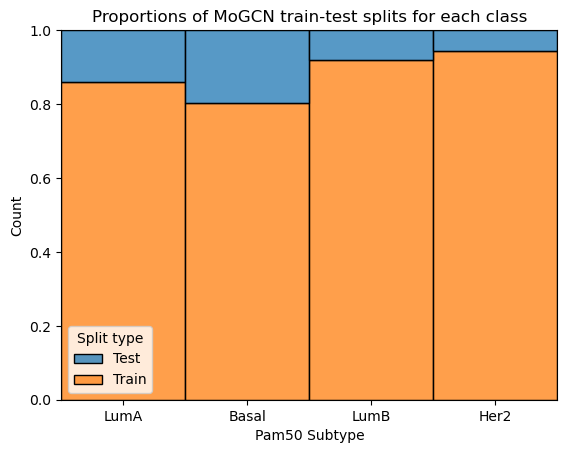

In [4]:
samples = pd.read_csv("./data/original/sample_classes.csv")
samples.rename(columns={"PAM50Call_RNAseq":"Pam50 Subtype"}, inplace=True)
samples.to_csv("./data/original/sample_classes.csv", index=False)

train_samples = pd.read_csv("./data/original/train_sample.csv")

plot_splits(samples, train_samples["Sample_ID"])

In [20]:
from sklearn.model_selection import train_test_split

test_size = 0.2
test_path = "./data/test_sample_stratified.csv"
# test_path = None
train_path = "./data/train_sample_stratified.csv"
# train_path = None

x, x_test = train_test_split(samples["Sample_ID"],test_size=test_size, stratify=samples["Pam50 Subtype"]) 

x.to_csv(train_path, index=False)
x_test.to_csv(test_path, index=False)

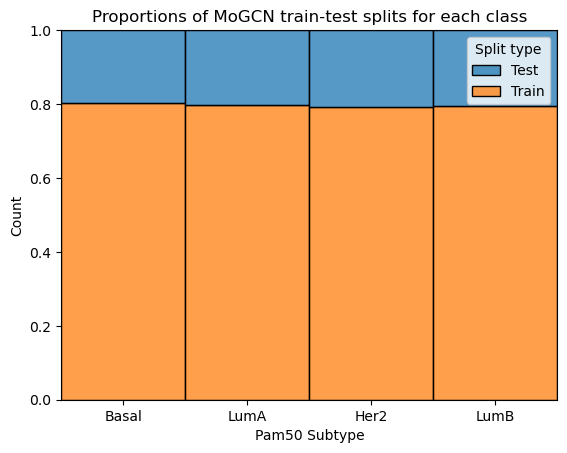

In [21]:
plot_splits(samples, x)

In [6]:
import snf

latent_df = pd.read_csv("./data/latent_data.csv")
data_x = latent_df.iloc[:, 1:].values

adj = snf.make_affinity(data_x, metric="sqeuclidean")
np.fill_diagonal(adj,0)
np.savetxt("./data/snf_latent_data.csv", adj, delimiter=",")

## Combined Data

In [8]:
surv_data = pd.read_csv("./data/original/TCGA-BRCA.survival.tsv", sep="\t")
surv_data.rename(columns={"OS":"Status", "_PATIENT":"Sample_ID","OS.time":"Survival_in_days"}, inplace=True)
surv_data["Sample_ID"] = surv_data["Sample_ID"].str.replace("TCGA-","")
surv_data.drop(["sample"], axis=1, inplace=True)
# surv_data["Sample_ID"] = surv_data["Sample_ID"].astype(str)
surv_data["Status"] = surv_data["Status"].astype(bool)
surv_data

,Status,Sample_ID,Survival_in_days
0,False,C8-A275,1
1,True,BH-A1F8,1
2,True,BH-A1F8,1
3,False,AC-A7VC,1
4,False,AN-A0AM,5
...,...,...,...
1255,False,B6-A0RE,7777
1256,False,B6-A0RN,8008
1257,False,B6-A0IA,8391
1258,False,B6-A0I5,8556


In [9]:
surv_data.value_counts(["Status"])

Status
False     1049
True       211
Name: count, dtype: int64

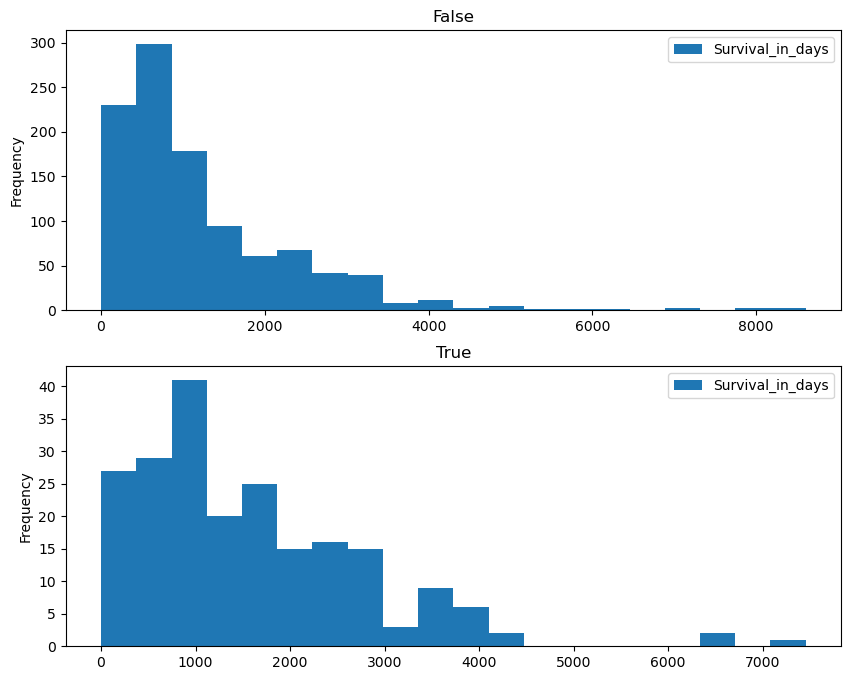

In [10]:
ax = surv_data.plot.hist(column=["Survival_in_days"], by="Status",bins=20, figsize=(10, 8))

In [12]:
samples = pd.read_csv("./data/original/sample_classes.csv")
samples

,Sample_ID,class,Pam50 Subtype
0,A1-A0SF,0,LumA
1,A1-A0SJ,0,LumA
2,A1-A0SK,2,Basal
3,A1-A0SO,2,Basal
4,A1-A0SQ,0,LumA
...,...,...,...
506,GM-A2DM,0,LumA
507,GM-A2DN,0,LumA
508,GM-A2DO,1,LumB
509,GM-A3NY,0,LumA


In [13]:
data = pd.merge(samples, surv_data, on="Sample_ID", how="inner")
data = data.drop_duplicates(["Sample_ID"])
data.reset_index(drop=True, inplace=True)
# data.to_csv("./data/MoGCN_data/gt_data.csv", index=False)
data

,Sample_ID,class,Pam50 Subtype,Status,Survival_in_days
0,A1-A0SF,0,LumA,False,1463
1,A1-A0SJ,0,LumA,False,416
2,A1-A0SK,2,Basal,True,967
3,A1-A0SO,2,Basal,False,852
4,A1-A0SQ,0,LumA,False,554
...,...,...,...,...,...
498,GM-A2DM,0,LumA,False,3226
499,GM-A2DN,0,LumA,False,3091
500,GM-A2DO,1,LumB,False,2596
501,GM-A3NY,0,LumA,False,1162


In [14]:
data.value_counts(["Status"])

Status
False     426
True       77
Name: count, dtype: int64

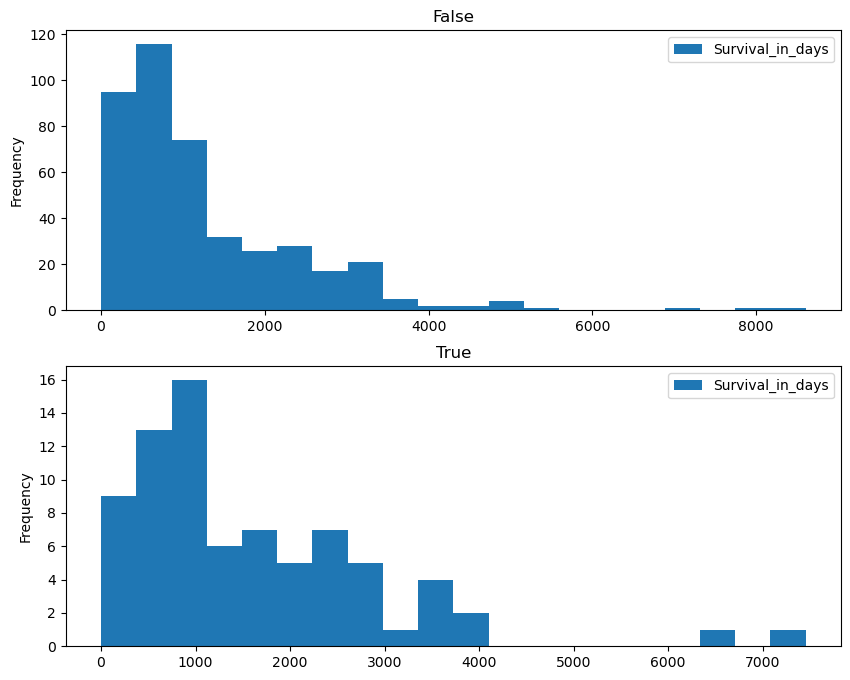

In [15]:
ax = data.plot.hist(column=["Survival_in_days"], by="Status",bins=20, figsize=(10, 8))

In [16]:
surv_data = pd.read_csv("./data/gt_data.csv")

# Latent
data_x = pd.read_csv("./data/latent_data.csv")
data_x.rename(columns={"Sample":"Sample_ID"}, inplace=True)
# mask is necessary since not all training samples are included into survival data
surv_mask = data_x["Sample_ID"].isin(surv_data["Sample_ID"])
data_x = data_x.loc[surv_mask]
data_x = data_x.reset_index(drop=True)
data_x.to_csv("./data/latent_data.csv", index=False)
data_x

,Sample_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,A1-A0SF,0.389629,0.378271,0.817272,0.185872,0.653398,0.523266,0.563777,0.844518,0.389710,...,0.738477,0.523745,0.426313,0.374602,0.253337,0.262283,0.596978,0.648576,0.577790,0.570242
1,A1-A0SJ,0.139893,0.857127,0.762419,0.103489,0.292722,0.362527,0.282818,0.640721,0.599967,...,0.477827,0.647984,0.325738,0.312618,0.780952,0.254149,0.692908,0.316893,0.409278,0.496837
2,A1-A0SK,0.906786,0.405142,0.044365,0.838600,0.116447,0.081864,0.968017,0.705532,0.583473,...,0.455708,0.050796,0.253531,0.314867,0.872509,0.145738,0.586646,0.373084,0.089392,0.925054
3,A1-A0SO,0.869220,0.285671,0.081229,0.759356,0.187241,0.095609,0.790846,0.864192,0.784442,...,0.918971,0.115172,0.280449,0.496118,0.752085,0.398116,0.394256,0.871220,0.264440,0.826854
4,A1-A0SQ,0.263627,0.775460,0.863038,0.185748,0.546318,0.362318,0.147700,0.846097,0.926222,...,0.504845,0.695824,0.289819,0.191543,0.397291,0.245373,0.810467,0.352339,0.675747,0.185202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498,GM-A2DM,0.357055,0.828480,0.828240,0.495465,0.395012,0.619649,0.429840,0.688040,0.864913,...,0.391343,0.475115,0.612108,0.569332,0.256772,0.469554,0.528284,0.551308,0.702343,0.281205
499,GM-A2DN,0.381064,0.505537,0.883634,0.494871,0.680610,0.562116,0.555042,0.783626,0.455041,...,0.555214,0.723799,0.683061,0.599071,0.278101,0.652184,0.144588,0.821716,0.511842,0.508863
500,GM-A2DO,0.705828,0.534463,0.887170,0.260767,0.789751,0.756769,0.596113,0.884951,0.794647,...,0.157276,0.912998,0.455141,0.451992,0.780666,0.647075,0.750688,0.909750,0.583875,0.514730
501,GM-A3NY,0.414094,0.222846,0.789861,0.128435,0.438268,0.762355,0.565647,0.422193,0.068813,...,0.580655,0.924745,0.841220,0.371055,0.215658,0.239172,0.671560,0.896420,0.496321,0.853399


In [ ]:
# SNF
df_snf = pd.read_csv("./data/MoGCN_results/SNF_fused_matrix.csv")
adj = df_snf.iloc[:, 1:].values
adj = adj[:, surv_mask]
adj = adj[surv_mask]
np.fill_diagonal(adj, 0)
np.savetxt("./data/snf_data.csv", adj, delimiter=",")

In [16]:
from sklearn.model_selection import train_test_split

test_size = 0.15
test_path = "./data/MoGCN_data/test_stratified.csv"
# test_path = None
train_path = "./data/MoGCN_data/train_stratified.csv"
# train_path = None

x, x_test = train_test_split(data["Sample_ID"],test_size=test_size, stratify=data["Pam50 Subtype"]) 

# x.to_csv(train_path, index=False)
# x_test.to_csv(test_path, index=False)

# K-fold stratification

In [19]:
data = pd.read_csv("./data/gt_data.csv")
data["Strat_ID"] = data["Pam50 Subtype"] + data["Status"].replace(
    {True: "_1", False: "_0"}
)
# data.to_csv("./data/gt_data.csv", index=False)
data


,Sample_ID,class,Pam50 Subtype,Status,Survival_in_days,Strat_ID
0,A1-A0SF,0,LumA,False,1463,LumA_0
1,A1-A0SJ,0,LumA,False,416,LumA_0
2,A1-A0SK,2,Basal,True,967,Basal_1
3,A1-A0SO,2,Basal,False,852,Basal_0
4,A1-A0SQ,0,LumA,False,554,LumA_0
...,...,...,...,...,...,...
498,GM-A2DM,0,LumA,False,3226,LumA_0
499,GM-A2DN,0,LumA,False,3091,LumA_0
500,GM-A2DO,1,LumB,False,2596,LumB_0
501,GM-A3NY,0,LumA,False,1162,LumA_0


In [6]:
data["Strat_ID"].value_counts()

Strat_ID
LumA_0     214
Basal_0     95
LumB_0      79
Her2_0      38
LumA_1      31
LumB_1      19
Basal_1     15
Her2_1      12
Name: count, dtype: int64

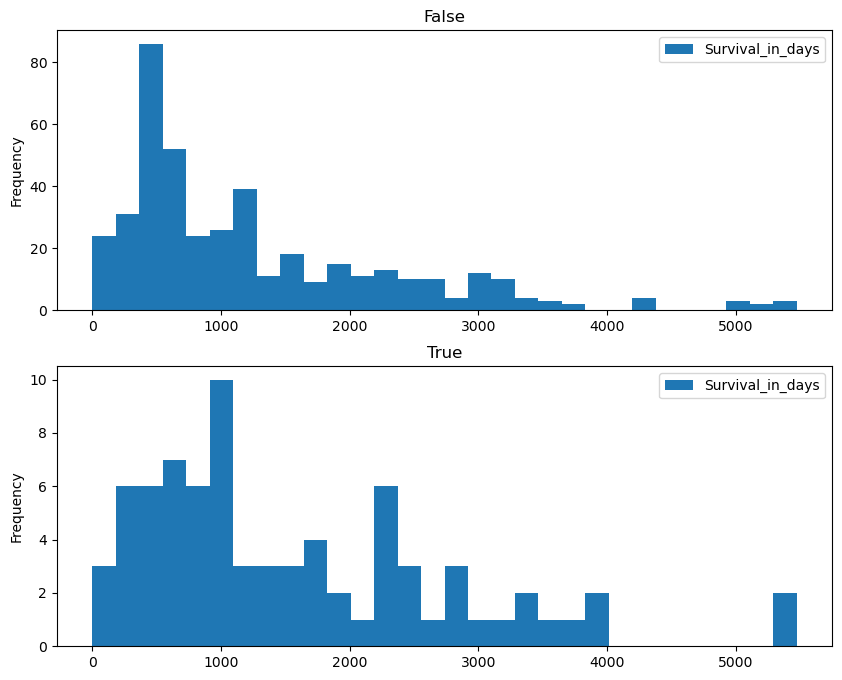

In [7]:
ax = data.plot.hist(column=["Survival_in_days"], by="Status",bins=30, figsize=(10, 8))

Status
False     340
True       62
Name: count, dtype: int64


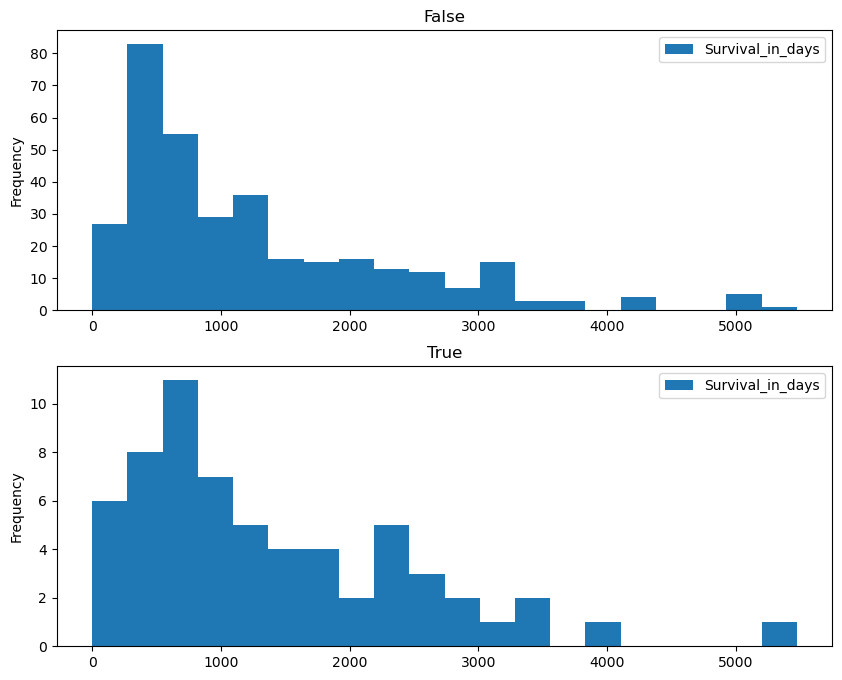

In [8]:
test_size = 0.20
x, x_test = train_test_split(
    data["Sample_ID"], test_size=test_size, stratify=data["Strat_ID"], random_state=42
)

test_path = "./data/MoGCN_data/test_strat_id.csv"
train_path = "./data/MoGCN_data/train_strat_id.csv"

# x.to_csv(train_path, index=False)
# x_test.to_csv(test_path, index=False)

train_mask = get_bool_mask(data, x)
print(data[train_mask].value_counts(["Status"]))
ax = data[train_mask].plot.hist(
    column=["Survival_in_days"], by="Status", bins=20, figsize=(10, 8)
)

Status
False     86
True      15
Name: count, dtype: int64


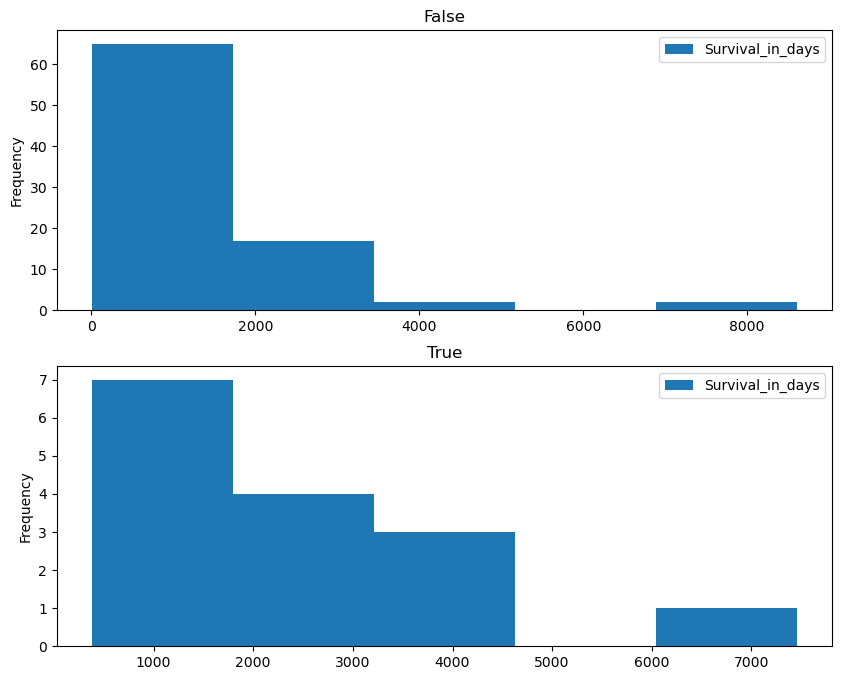

In [13]:
gt_df = pd.read_csv("./data/gt_data.csv")
test_mask = get_bool_mask(gt_df, pd.read_csv("./data/test_strat_id.csv")["Sample_ID"])


print(gt_df[test_mask].value_counts(["Status"]))
ax = gt_df[test_mask].plot.hist(
    column=["Survival_in_days"], by="Status", bins=5, figsize=(10, 8)
)


 === Fold 1 === 
Status
False     68
True      13
Name: count, dtype: int64


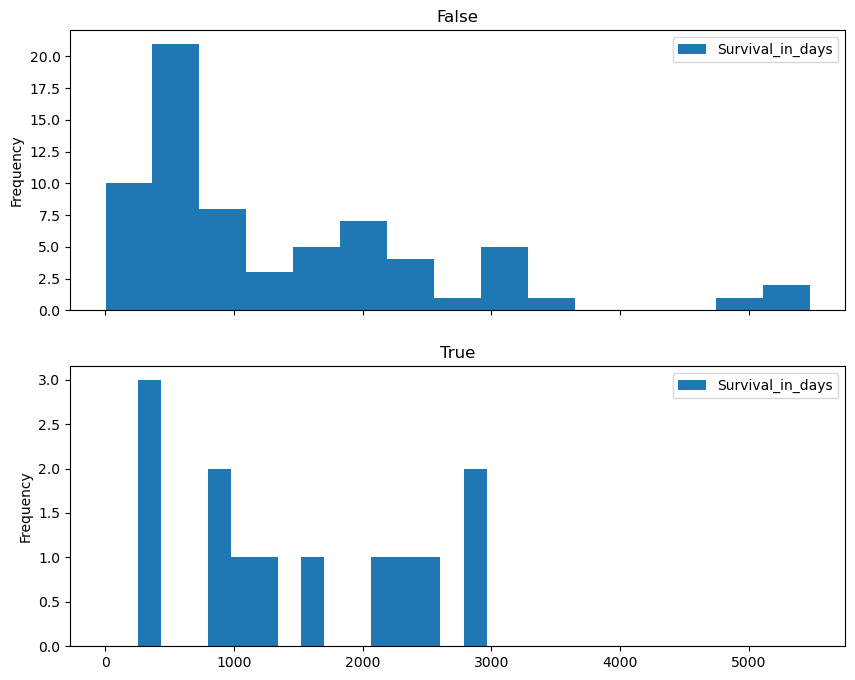


 === Fold 2 === 
Status
False     68
True      13
Name: count, dtype: int64


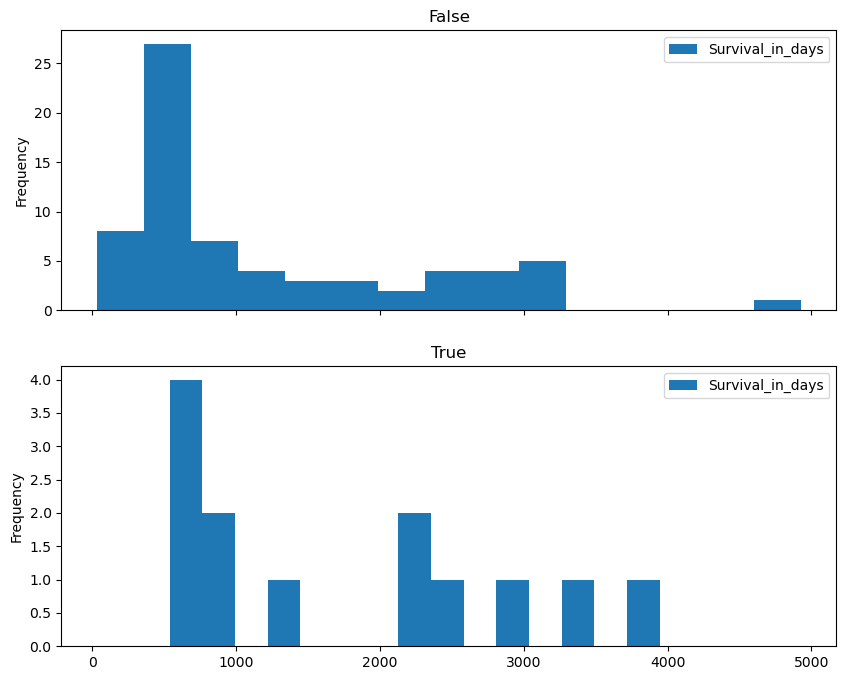


 === Fold 3 === 
Status
False     67
True      13
Name: count, dtype: int64


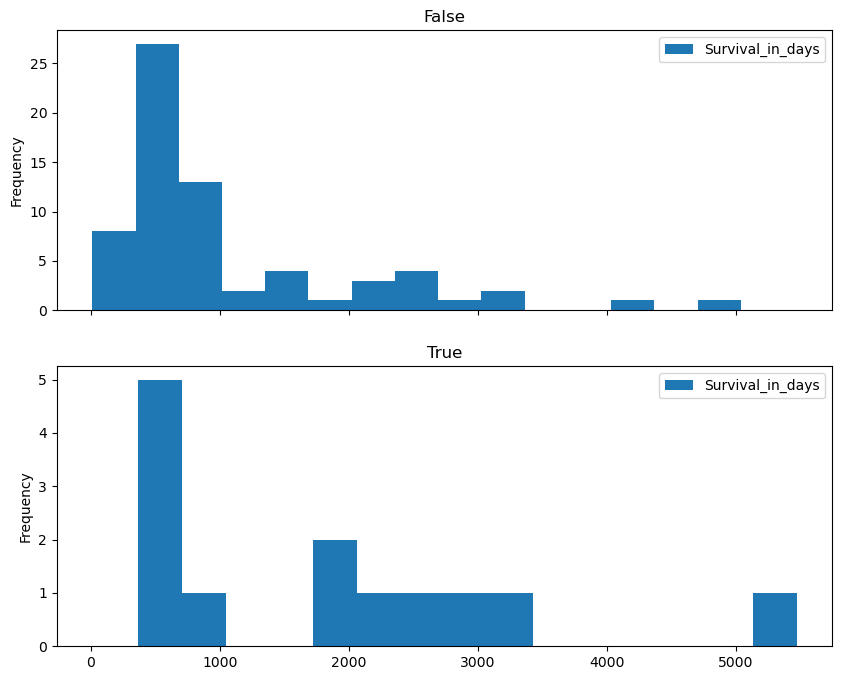


 === Fold 4 === 
Status
False     61
True      19
Name: count, dtype: int64


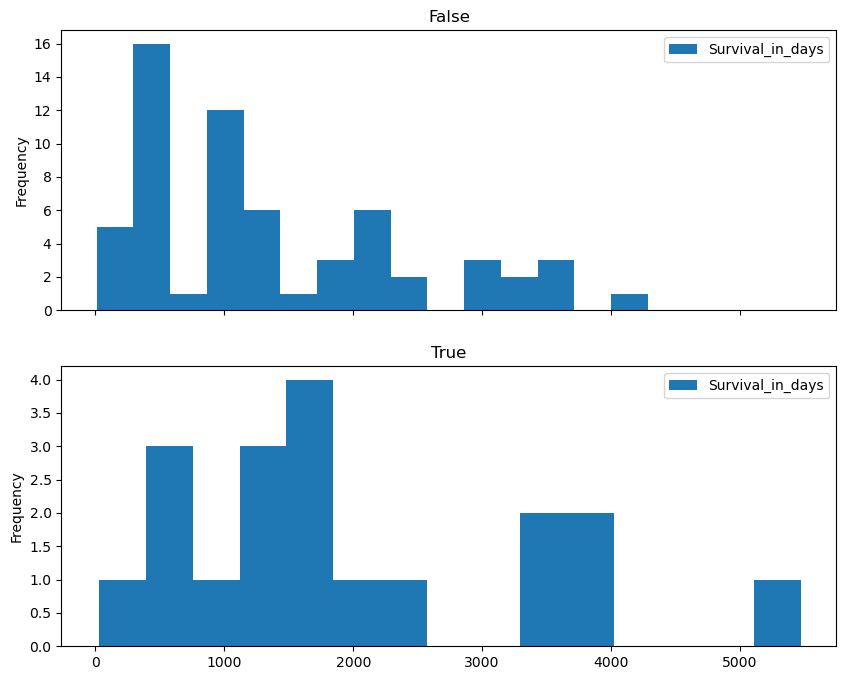


 === Fold 5 === 
Status
False     71
True       9
Name: count, dtype: int64


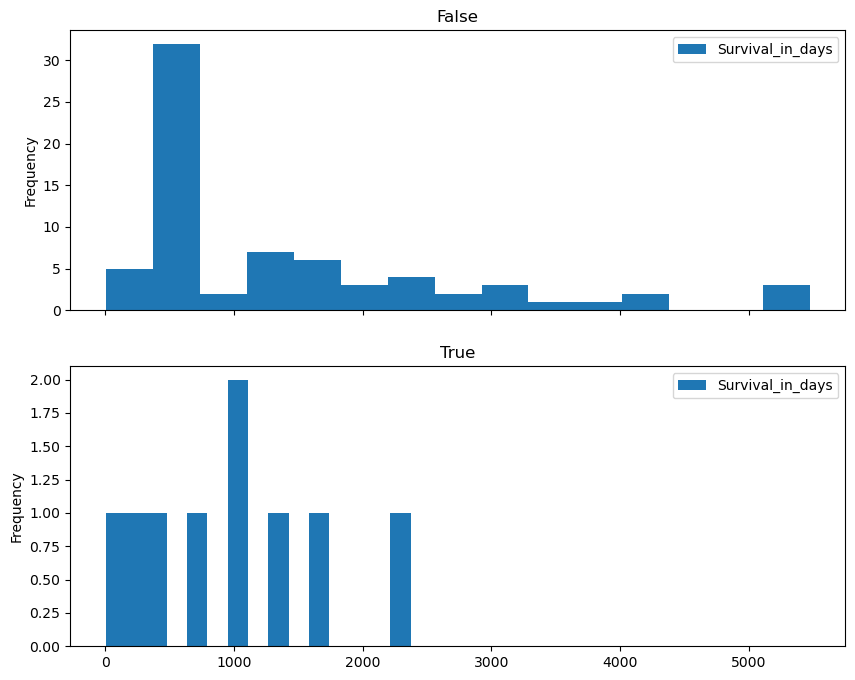

In [10]:
from utils.data import get_fold_masks

n_splits=5
path = f"./data/{n_splits}_fold"

gt_df = pd.read_csv("./data/gt_data.csv")
train_mask = get_bool_mask(gt_df, pd.read_csv("./data/train_strat_id.csv")["Sample_ID"])


skf = StratifiedKFold(n_splits=n_splits, random_state=42,shuffle=True)
train_ids = data["Sample_ID"][train_mask]
train_y = data["Strat_ID"][train_mask]

for k, (train_index, val_index) in enumerate(skf.split(train_ids, train_y)):
    print(f"\n === Fold {k+1} === ")

    train_mask = get_bool_mask(data, data["Sample_ID"][train_index])
    val_mask = get_bool_mask(data, data["Sample_ID"][val_index])
    
    # np.savetxt(
    #     os.path.join(path, f"train_fold_{k+1}.csv"),
    #     train_mask,
    #     delimiter=",",
    #     fmt="%s",
    # )
    # np.savetxt(
    #     os.path.join(path, f"val_fold_{k+1}.csv"),
    #     val_mask,
    #     delimiter=",",
    #     fmt="%s",
    # )

    # fold_train = np.genfromtxt(
    #         os.path.join(path, f"train_fold_{k+1}.csv"),
    #         delimiter=",",
    #         dtype=bool,
    #     )
    # fold_val = np.genfromtxt(
    #         os.path.join(path, f"val_fold_{k+1}.csv"),
    #         delimiter=",",
    #         dtype=bool,
    #     )
    # print((train_mask==fold_train[k]).all())
    # print((val_mask==fold_val[k]).all())

    print(data[val_mask].value_counts(["Status"]))
    ax = data[val_mask].plot.hist(column=["Survival_in_days"], by="Status",bins=15, figsize=(10, 8), sharex=True)
    plt.show()
            